# Анализ оттока клиентов телеком компании

**Цель** - построить и обучить модель, которая будет прогнозировать отток клиентов. Целевая метрика - **ROC-AUC** не ниже 0.88

Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);

- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
- Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

Данные состоят из файлов, полученных из разных источников:

- contract.csv — информация о договоре;

- personal.csv — персональные данные клиента;

- internet.csv — информация об интернет-услугах;

- phone.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020.

## План

1. [x] Exploratory Data Analysis
    - [X] определиться, что делать с пропусками
    - [X] создать столбец с бинарным целевым признаком, зависящим от даты окончания (ее наличия?) контракта 
    - [X] аккуратное объединение датафреймов в один. Мердж по убыванию кол-ва данных к самому большому, чтобы ничего не потерять. Надо еще посмотреть, может добавить какие-то доп составные признаки с помощью сводных таблиц или расчетов (например, сколько дней длился контракт пользователя)
2. [x] Исследовательский анализ данных
    - [X] распределения данніх о  ежемесячных платежах всех клиентов и тех, кто ушел
    - [X] статистические метрики для всех клиентов, и тех, кто ушел: среднее, мин, макс, медиана, квантили
    - [X] графики с долями клиентов, которые используют интернет, телефонию и обе услуги
    - [X] графики с долями клиентов, которые используют доп услуги
3. [x] Подготовить данные для моделей
    - [x] нормализация и удаление выбросов 
    - [x] исследование на мультиколлинеарность
    - [x] исключение незначительных признаков
    - [x] кодирование категориальных признаков
    - [x] масштабирование количественных признаков 
    - [x] проверка на дисбаланс классов и избавление, если таковой имеется
4. [x] Обучение простых моделей с автоподбором параметров.
5. [x] Попробовать градиентный бустинг (например модели CatBoost и LightBGM)
6. [x] Выбор, тестирование лучшей модели и сравнение ее с Dummy моделью
7. [x] Выводы, отчет

## Импорты, функции, чтение данных

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer

from sklearn.utils import shuffle

import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow import keras
 
import warnings
warnings.filterwarnings('ignore')

In [3]:
try: 
    df_contract = pd.read_csv('./data/contract.csv', na_values=' ')
    df_internet = pd.read_csv('./data/internet.csv', na_values=' ')
    df_personal = pd.read_csv('./data/personal.csv', na_values=' ')
    df_phone = pd.read_csv('./data/phone.csv', na_values=' ')
except:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv', na_values=' ')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv', na_values=' ')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv', na_values=' ')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv', na_values=' ')

In [4]:
def quick_description(df):
    df.info()
    print('Кол-во дубликатов:', df.duplicated().sum())
    print('Кол-во уникальных пользователей:', len(df['customerID'].unique()))
    print('Кол-во пропусков:', df.isna().sum())

In [5]:
def numeric_feature_distribution(df, column):
      filtered_df=df[column]
      filtered_df_notclient=df[df['Churn'] == 'Yes'][column]
      mean_full = filtered_df.mean()
      mean_notclient =  filtered_df_notclient.mean()
      median_full = filtered_df.median()
      median_notclient =  filtered_df_notclient.median()
      min_full = filtered_df.min()
      min_notclient =  filtered_df_notclient.min()
      max_full = filtered_df.max()
      max_notclient =  filtered_df_notclient.max()
      q1_full = filtered_df.quantile(0.25)
      q3_full = filtered_df.quantile(0.75)
      q1_notclient = filtered_df_notclient.quantile(0.25)
      q3_notclient = filtered_df_notclient.quantile(0.75)
      print ('\033[94m'+column+'\033[0m')
      print('\033[1m'+'Все клиенты:'+'\033[0m')  
      print('Медиана: {:.0f}'.format(median_full),', Среднее: {:.0f}'.format(mean_full),
            ', Минимальное значение: {:.0f}'.format(min_full), ',  Максимальное значение: {:.0f}'.format(max_full),
            ', 25% квантиль: {:.0f}'.format(q1_full), ', 75% квантиль: {:.0f}'.format(q3_full))
      print ('\033[1m'+'Ушедшие клиенты:'+'\033[0m')
      print('Медиана: {:.0f}'.format(median_notclient),', Среднее: {:.0f}'.format(mean_notclient),
            ', Минимальное значение: {:.0f}'.format(min_notclient), ',  Максимальное значение: {:.0f}'.format(max_notclient),
            ', 25% квантиль: {:.0f}'.format(q1_notclient), ', 75% квантиль: {:.0f}'.format(q3_notclient))

      ax = df.plot(kind='hist', y=column, ec='black', bins=30, 
                                    linewidth=1, alpha=0.5, label='Все клиенты', color='g')
      filtered_df_notclient.plot(kind='hist', y=column, ec='black', bins=30,linewidth=1, alpha=0.5, 
                              label='Ушедшие клиенты', ax=ax, figsize=(12,6),grid=True, legend=True, fontsize = 15, color='b')
      ax.set_ylabel('Частота значений', fontsize=13)
      ax.set_xlabel(column, fontsize=13)
      ax.set_title('Распределение по ' + column, fontsize=17, fontweight='bold')
      plt.show()

In [6]:
def boxplot_distribution(df, column):
    plt.figure(figsize=(15,3))
    sns.boxplot(df[column], color='g').set(xlabel='Значения', ylabel=column)                          
    plt.title(label='"Ящик с усами" по ' + column, fontdict={'fontsize': 18})
    plt.show()

In [7]:
# Построение графиков распределения категориальных признаков в разрезе лояльный/нелояльный клиент 
def categorial_feature_distribution(df, categories, nrows, ncols, size=15, rotation=0):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size, size * 2))
    for idx, feat in enumerate(categories):
        sns.countplot(df[feat], hue='Churn', data=df, ax=ax[idx // ncols, idx % ncols])
        ax[idx//ncols, idx%ncols].set_xticklabels(ax[idx//ncols, idx%ncols].get_xticklabels(), rotation=rotation)
        ax[idx//ncols, idx%ncols].set_title('Распределение по ' + feat)
        ax[idx//ncols, idx%ncols].set_ylabel('Количество');
        ax[idx//ncols, idx%ncols].title.set_size(16)

In [8]:
def model_learning(model, parameters, train_features, train_target):
    roc_auc_scorer=make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
    grid = GridSearchCV(model, parameters, scoring=roc_auc_scorer, cv=5, n_jobs = -1)
    grid.fit(train_features, train_target)
    print('Лучшая оценка на валидации: ', grid.best_score_)
    print('Лучшие гиперпараметры модели на валидации: ', grid.best_params_)
    print('Лучшая модель: ', grid.best_estimator_)
    return grid.best_estimator_

In [9]:
def feature_importance(model, train_features):
    feats = {}
    for feature, importance in zip(train_features.columns, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale = 5)
    sns.set(color_codes=True, font_scale = 1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(30,15)
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
    plt.xlabel('Важность', fontsize=25, weight = 'bold')
    plt.ylabel('Признаки', fontsize=25, weight = 'bold')
    plt.title('Важность признаков', fontsize=25, weight = 'bold')
    display(plt.show())
    display(importances)

In [10]:
def test_scoring(model, test_features, test_target, isNeuron=False):
    
    pred_proba_test = model.predict(test_features) if isNeuron else model.predict_proba(test_features)[:, 1]
    pred_test = model.predict(test_features)
    print('Test Metrics:')
    print('Accuracy: ', round(model.score(test_features, test_target), 3))
    print('Presicion: ', round(precision_score(test_target, pred_test), 3))
    print('Recall: ', round(recall_score(test_target, pred_test), 3))
    print('AUC-ROC: ', round(roc_auc_score(test_target, pred_proba_test), 3))
    fpr, tpr, thresholds = roc_curve(test_target, pred_proba_test)

    sns.set()
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая')
    plt.show()

In [11]:

def upsample(features, target, repeat):
    features_zeros=features[target==0]
    features_ones=features[target==1]
    target_zeros=target[target==0]
    target_ones=target[target==1]
    features_upsampled=pd.concat([features_zeros]+[features_ones]*repeat)
    target_upsampled=pd.concat([target_zeros]+[target_ones]*repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled,random_state=666)
    return features_upsampled, target_upsampled

In [12]:
def downsample(features, target, fraction):
    features_zeros=features[target==0]
    features_ones=features[target==1]
    target_zeros=target[target==0]
    target_ones=target[target==1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=666)]+[features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=666)]+[target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,random_state=666)
    return features_downsampled, target_downsampled

## Анализ и предобработка данных

### Контракты

In [13]:
display(df_contract)
quick_description(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
Кол-во дубликатов: 0
Кол-во уникальных пользователей: 7043
Кол-во пропусков: customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64


Всего 7043 пользователя. Дубликатов нет. Есть 11 пропусков в TotalCharges. Подоробнее осмотрим их 

In [14]:
nan_contract_rows = df_contract[df_contract['TotalCharges'].isna()]

display(nan_contract_rows)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


In [15]:
print('Доля пропусков', len(nan_contract_rows)/df_contract.shape[0] * 100 )


Доля пропусков 0.1561834445548772


Все пропуски за одно число. Доля пропусков незначительная. Т.к "Информация о договорах актуальна на 1 февраля 2020.", это означает, что данные, судя по всему, за день выгрузки. Смысловой нагрузки они никакой не несут, да и их ничтожно мало. Их можно удалить после объединения датафреймов.

In [16]:
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')


Добавим целевой признак оттока клиента - **Сhurn**. Если в признаке EndDate присутствует дата, значит клиент ушел (Yes), иначе еще в сети (No)

In [17]:
df_contract['Churn'] = df_contract['EndDate'].apply(lambda x: x if x == 'No' else 'Yes')
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Приведем *BeginDate* к типу Date. Для *EndDate* выставим дату выгрузки данных по двум причинам:
1) Это понадобится нам, чтобы расчиатать "время жизни" клиента
2) Это не исказит данные, т.к. мы уже выделели целевой признак в *Churn* 

In [18]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x), format='%Y-%m-%d')
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Churn             7043 non-null   object        
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 495.3+ KB


Добавим признак "Lifetime" - время жизни клиента от *BeginDate* до *EndDate* в днях

In [19]:
df_contract['Lifetime'] = (df_contract['EndDate'] - df_contract['BeginDate']).astype('timedelta64[D]').astype('int')
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Lifetime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,No,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,No,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,61


### Интернет

In [20]:
display(df_internet)
quick_description(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
Кол-во дубликатов: 0
Кол-во уникальных пользователей: 5517
Кол-во пропусков: customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


Всего 5517 пользователей с интернетом, что намного меньше, чем общее число контрактов. Не все используют интернет
Дубликатов нет. Пропусков нет

### Телефон

In [21]:
display(df_phone)
quick_description(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
Кол-во дубликатов: 0
Кол-во уникальных пользователей: 6361
Кол-во пропусков: customerID       0
MultipleLines    0
dtype: int64


Всего 6361 пользователь со связью. Меньше, чем общее кол-во контрактов. Не все используют связь.
Пропусков нет, дубликатов нет

### Информация о клиенте

In [22]:
display(df_personal)
quick_description(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
Кол-во дубликатов: 0
Кол-во уникальных пользователей: 7043
Кол-во пропусков: customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


In [23]:
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

Информация есть о всех пользователях контрактов. Пропусков нет. Дубликатов нет.

### Merge

Объединим все датафреймы, удалим клиентов, которые только присоединились и заполним пропуски для тех, кто не пользуется какой-либу услуго категорией 'Do not use'

In [24]:
df_full = pd.merge(df_contract, df_personal, on = 'customerID',how= 'left')
df_full = df_full.dropna()

df_full = pd.merge(df_full, df_phone, on = 'customerID',how= 'left')
df_full = pd.merge(df_full, df_internet, on = 'customerID',how= 'left')
# Здесь нет числовых признаков с пропусками, так что можно заменить все
df_full = df_full.fillna('Do not use')
display(df_full.head())
df_full.info()


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Lifetime,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,No,31,Female,No,Yes,No,Do not use,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,No,1036,Male,No,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,61,Male,No,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,No,1371,Male,No,No,No,Do not use,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,61,Female,No,No,No,No,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Churn             7032 non-null   object        
 9   Lifetime          7032 non-null   int32         
 10  gender            7032 non-null   object        
 11  SeniorCitizen     7032 non-null   object        
 12  Partner           7032 non-null   object        
 13  Dependents        7032 non-null   object        
 14  MultipleLines     7032 n

Проверим есть ли аномальные пользователи, которые имеют контракт, но не пользуются ни связью, ни интернетом

In [25]:
display(df_full[(df_full['MultipleLines'].isna())&(df_full['InternetService'].isna())])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Lifetime,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


Таких пользователей нет. Взглянем на значения категориальных признаков

In [26]:
df_categorial = list(df_full.columns)[3:6]
df_categorial = df_categorial + list(df_full.columns)[11:20]
df_categorial.append('Churn')
df_categorial.append('gender')

for categorial_feature in df_categorial:
    print(categorial_feature, df_full[categorial_feature].unique())


Type ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
SeniorCitizen ['No' 'Yes']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
MultipleLines ['Do not use' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'Do not use']
OnlineSecurity ['No' 'Yes' 'Do not use']
OnlineBackup ['Yes' 'No' 'Do not use']
DeviceProtection ['No' 'Yes' 'Do not use']
TechSupport ['No' 'Yes' 'Do not use']
Churn ['No' 'Yes']
gender ['Female' 'Male']


В категориях никаких аномалий нет

### Вывод

* Провверены пропуски и дубликаты во всех датафреймах

* удалены 11 пользователей, у которых не было TotalCharges по причине присоединения в день выг рузки данных

* Добавлен целевой признак *Churn* зависящий от наличия даты окончания контракта

* Даты приведены в к соответствующему типу

* Все сведено в один датафрейм

## Исследовательский анализ данных

### Количественные признаки

Посмотрим на распределение разных признаков среди лояльных и ушедших клиентов. Начнем со времени жизни

Lifetime
Все клиенты:
Медиана: 883 , Среднее: 988 , Минимальное значение: 30 ,  Максимальное значение: 2191 , 25% квантиль: 275 , 75% квантиль: 1676
Ушедшие клиенты:
Медиана: 304 , Среднее: 547 , Минимальное значение: 30 ,  Максимальное значение: 2191 , 25% квантиль: 61 , 75% квантиль: 883


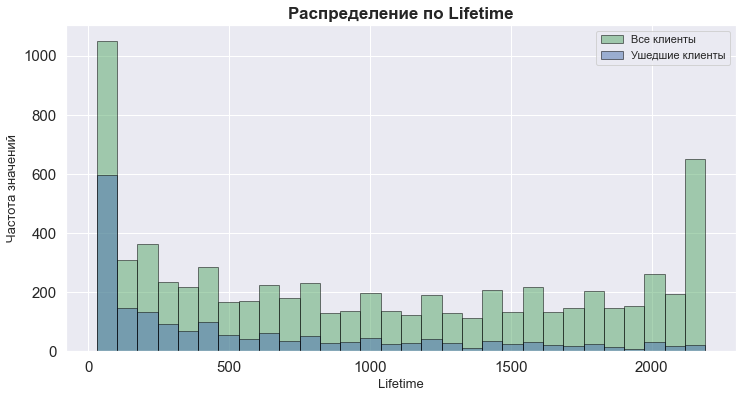

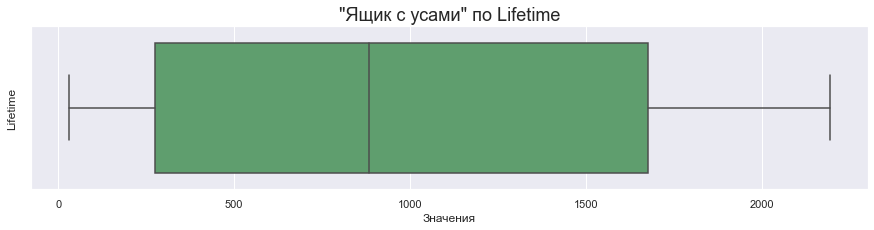

In [27]:
numeric_feature_distribution(df_full, 'Lifetime')
boxplot_distribution(df_full, 'Lifetime')

Видны всплески у значений длительности "меньше полугода" и "дольше трех лет". Распределение бимодально. Значит у нас есть разные выборки в одной и фактор, корый этому способствует.

Вывод: больше всего уходит совсем новых клиентов, что есть больше половины всех новых клиентов. Остальные выходы из сети распределены равномерно.

MonthlyCharges
Все клиенты:
Медиана: 70 , Среднее: 65 , Минимальное значение: 18 ,  Максимальное значение: 119 , 25% квантиль: 36 , 75% квантиль: 90
Ушедшие клиенты:
Медиана: 80 , Среднее: 74 , Минимальное значение: 19 ,  Максимальное значение: 118 , 25% квантиль: 56 , 75% квантиль: 94


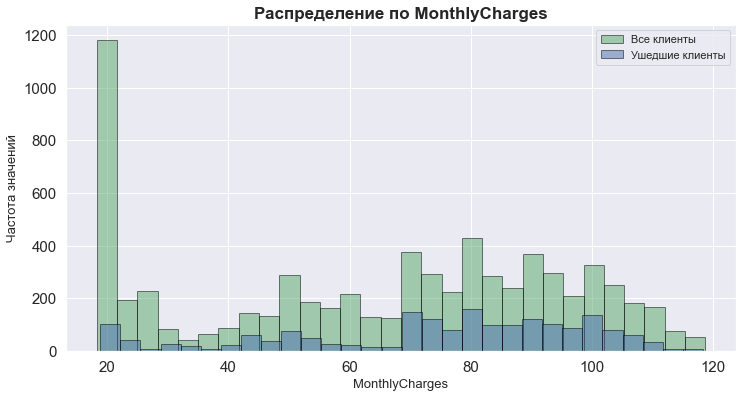

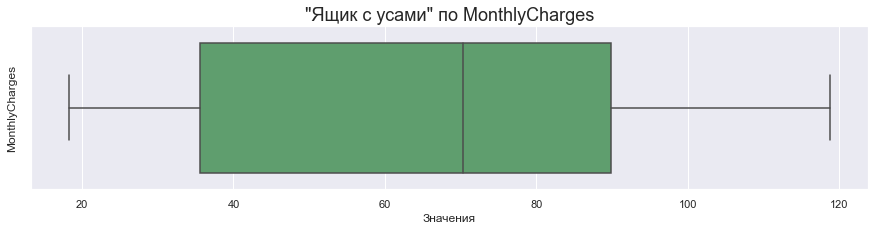

In [28]:
numeric_feature_distribution(df_full, 'MonthlyCharges')
boxplot_distribution(df_full, 'MonthlyCharges')

Видны всплески на значениях 20 и 80. Распределение бимодальное. Значит у нас есть разные выборки в одной и фактор, корый этому способствует.

Больше всех уходят клиенты медиум+ сегмента, чей месячный платеж составляетот 70 до 11 у.е., а так же те, у кого минимальных платеж. На лицо явный признак, влияющий на целевой

TotalCharges
Все клиенты:
Медиана: 1397 , Среднее: 2283 , Минимальное значение: 19 ,  Максимальное значение: 8685 , 25% квантиль: 401 , 75% квантиль: 3795
Ушедшие клиенты:
Медиана: 704 , Среднее: 1532 , Минимальное значение: 19 ,  Максимальное значение: 8685 , 25% квантиль: 134 , 75% квантиль: 2331


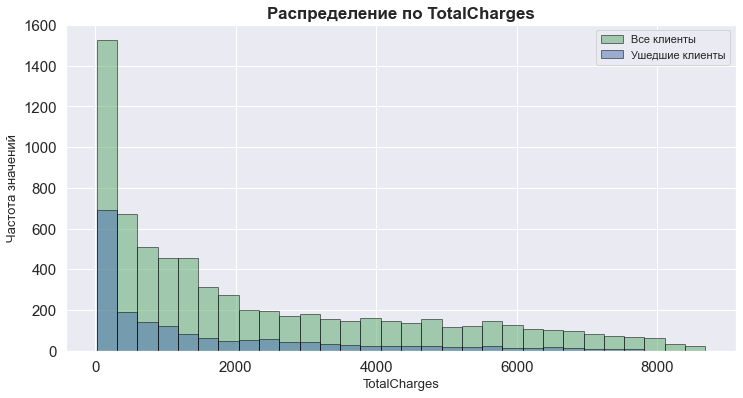

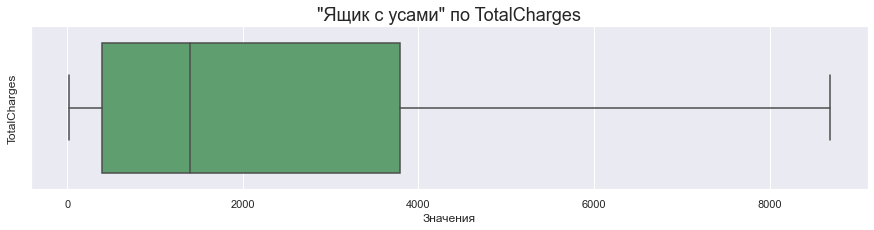

In [29]:
numeric_feature_distribution(df_full, 'TotalCharges')
boxplot_distribution(df_full, 'TotalCharges')

Распределение нормальное.

Еще одно подтверждение тому, что много клиентов уходит сразу после подключения

### Корреляция количественных признаков с разделением на лояльность

,MonthlyCharges,TotalCharges,Lifetime
MonthlyCharges,1.000000,0.651065,0.246715
TotalCharges,0.651065,1.000000,0.825811
Lifetime,0.246715,0.825811,1.000000


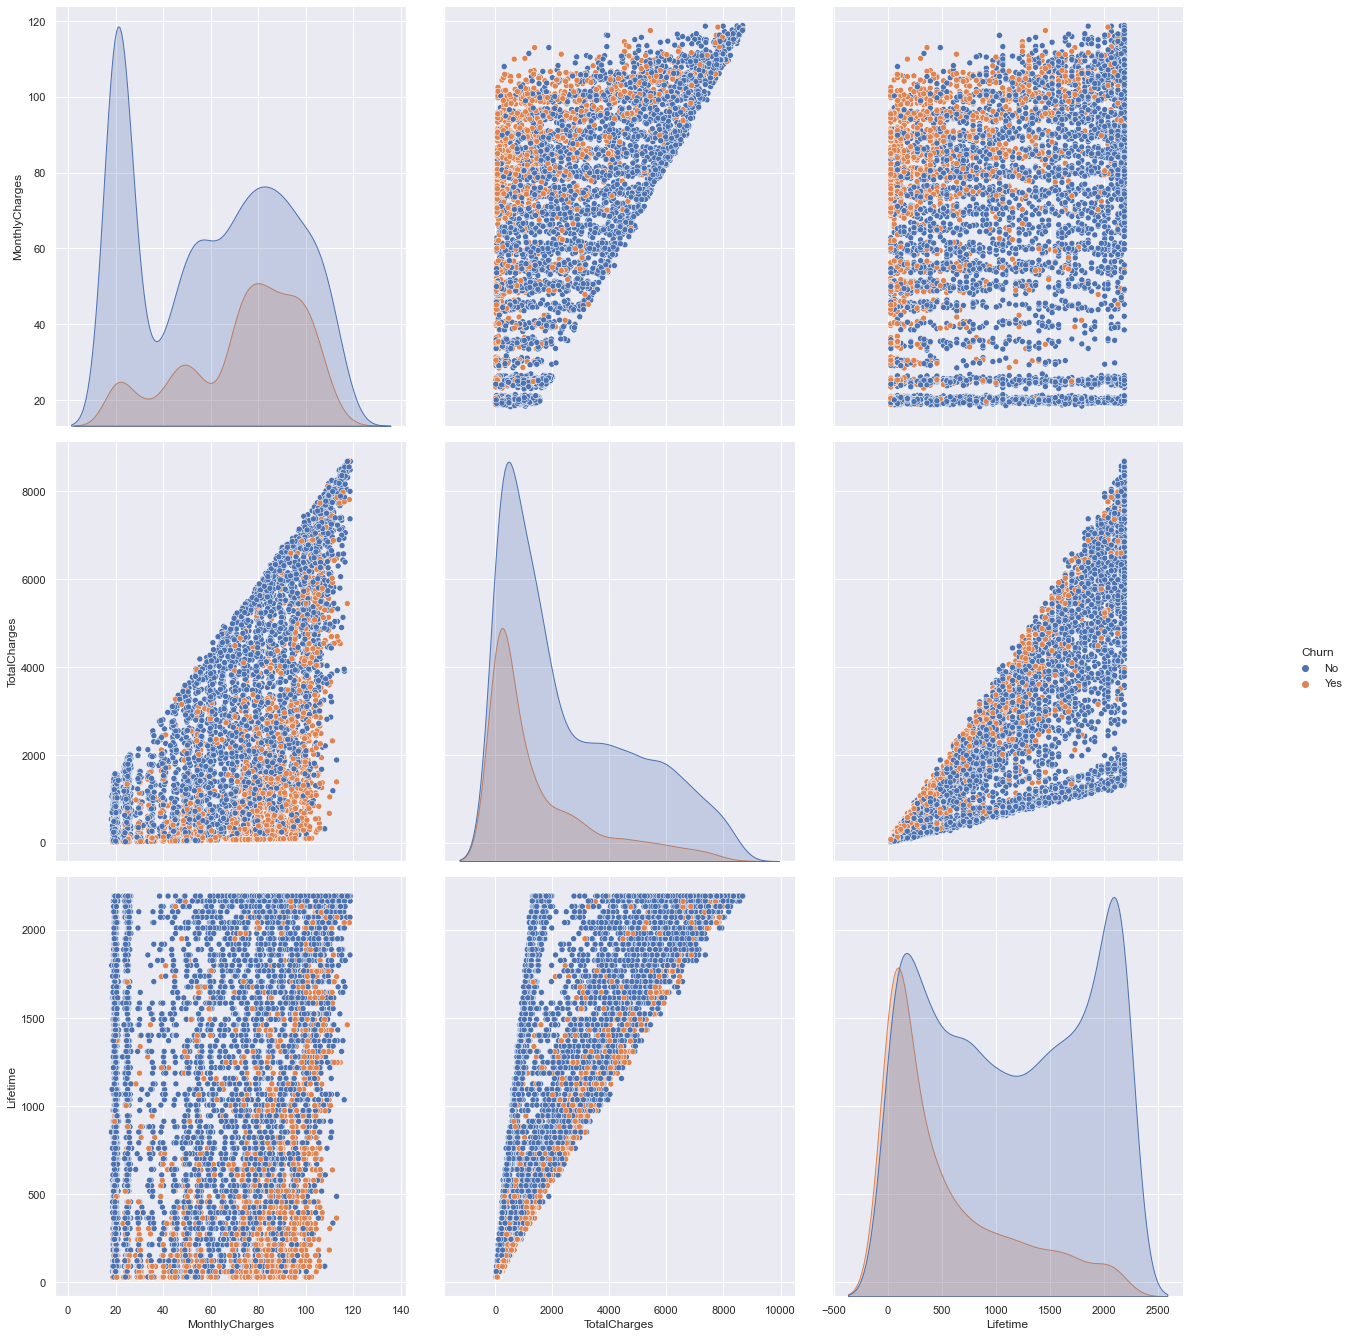

In [30]:
sns.pairplot(df_full, hue='Churn').fig.set_size_inches(20,20)
df_full.corr()


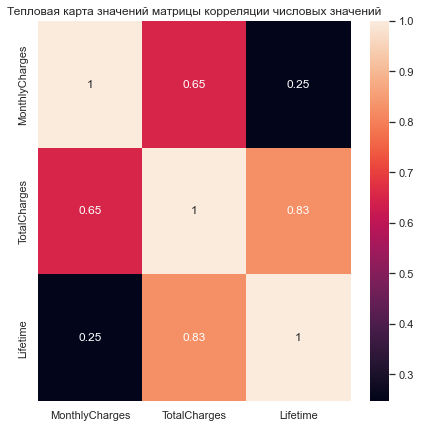

In [31]:
plt.figure(figsize=(7,7))
plt.title('Тепловая карта значений матрицы корреляции числовых значений')
sns.heatmap(df_full.corr(), annot=True);

Очевидно, что некоторые признаки довольно сильно коррелируют между собой:

- *Lifetime* и *Total Charges* Линейно зависимы 

- *Total Charges* и *Monthly Charges*

Вывод есть смысл позже избавиться от старого признака TotalCharges, и оставить Lifetime и MonthlyChangers

### Категориальные признаки с разделением на лояльность

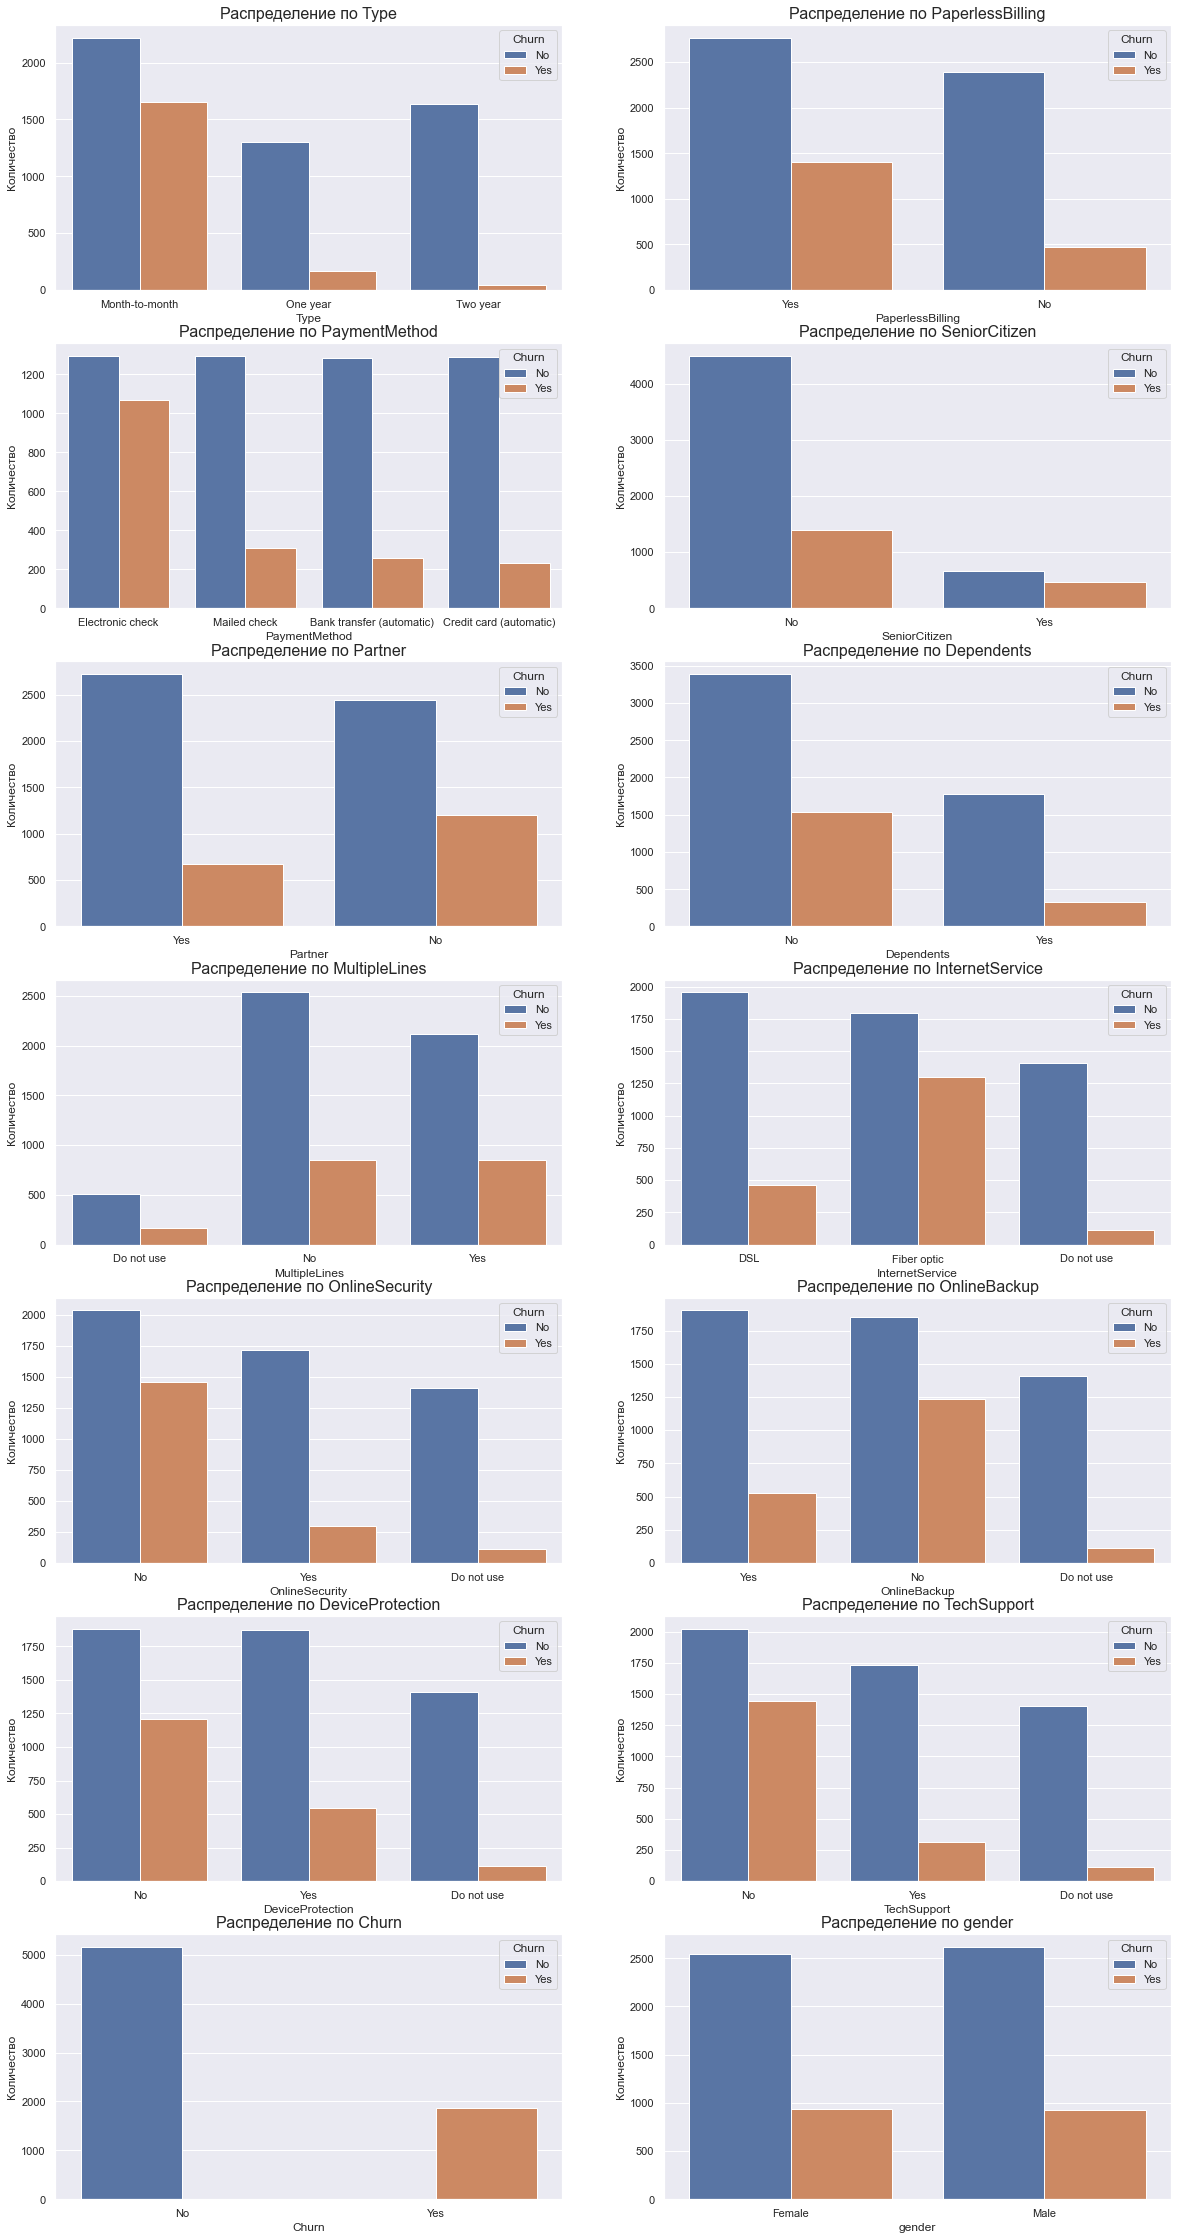

In [32]:
categorial_feature_distribution(df_full, df_categorial, nrows=7, ncols=2, size=20)

Выводы: 

* чаще уходят те, кто оплачивает помесячно
* чаще уходят те, кто использует *Electronic Check* и *Paperless Billing*. Возможно с некой онлайн системой оплаты есть проблемы
* Использование доп услуг *Device Protection*, *Online Security*, *Online Backup*, *Fiber Optic*, *Tech Support* явно недостаточно, чтобы мотивировать клента остаться
* Пенсионеры уходят чаще по очевидным неконтролируемым причинам (отстутствие денег, проблемы со здоровьем, смерть)
* Одинокие люди уходят чаще, возможно по неконтролируемым причинам (переезд в город без покрытия, и тд) 

### Доли интренет пользователей среди всех клиентов и среди ушедших

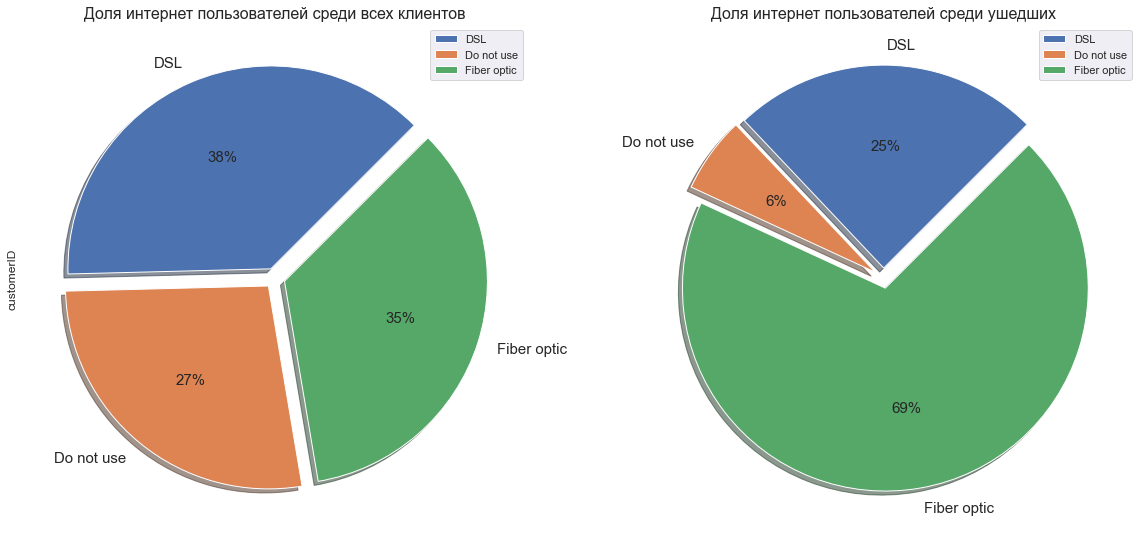

In [33]:
internet_pivot = df_full[df_full['Churn'] == 'No'].pivot_table(index='InternetService', values='customerID', 
                aggfunc = 'count')
internet_churn_pivot = df_full[df_full['Churn'] == 'Yes'].pivot_table(index='InternetService', values='customerID', 
                aggfunc = 'count')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
internet_pivot.plot(ax=ax1, kind='pie',shadow=True, subplots=True, fontsize=15,figsize=(6,6), startangle=45,autopct=lambda p: '{:.0f}%'.format(p), explode = (0.05, 0.05, 0.05))
ax1.set_title('Доля интернет пользователей среди всех клиентов')
ax1.title.set_size(16)

internet_churn_pivot.plot(ax=ax2, kind='pie',shadow=True, subplots=True, fontsize=15,figsize=(6,6), startangle=45,autopct=lambda p: '{:.0f}%'.format(p), explode = (0.05, 0.05, 0.05))
ax2.set_title('Доля интернет пользователей среди ушедших')
ax2.title.set_size(16)

plt.legend(loc=1)
plt.axis('off')
plt.show()

Вывод: Среди ушедших клиентов большая доля пользователей Fiber Optic. Есть вероятность, что их не устраивало его качество

### Доли пользователей связи среди всех клиенто и среди ушедших, а так же кто чем пользовался

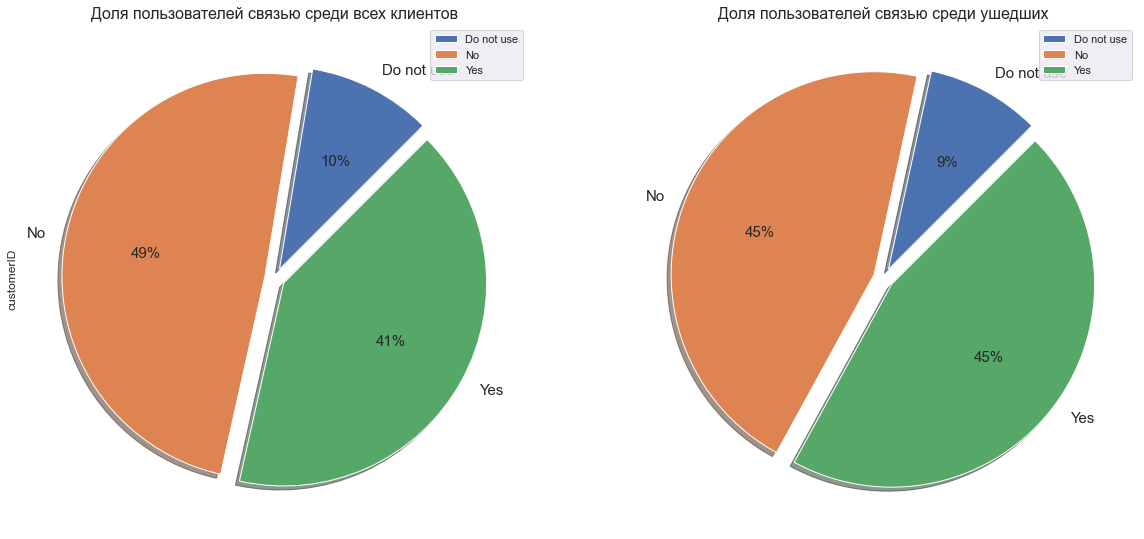

In [34]:
internet_pivot = df_full[df_full['Churn'] == 'No'].pivot_table(index='MultipleLines', values='customerID', 
                aggfunc = 'count')
internet_churn_pivot = df_full[df_full['Churn'] == 'Yes'].pivot_table(index='MultipleLines', values='customerID', 
                aggfunc = 'count')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
internet_pivot.plot(ax=ax1, kind='pie',shadow=True, subplots=True, fontsize=15,figsize=(6,6), startangle=45,autopct=lambda p: '{:.0f}%'.format(p), explode = (0.05, 0.05, 0.05))
ax1.set_title('Доля пользователей связью среди всех клиентов')
ax1.title.set_size(16)

internet_churn_pivot.plot(ax=ax2, kind='pie',shadow=True, subplots=True, fontsize=15,figsize=(6,6), startangle=45,autopct=lambda p: '{:.0f}%'.format(p), explode = (0.05, 0.05, 0.05))
ax2.set_title('Доля пользователей связью среди ушедших')
ax2.title.set_size(16)

plt.legend(loc=1)
plt.axis('off')
plt.show()

Вывод: Здесь доли для ушедших и лояльных пользователей почти одинаковы

### Вывод

Возможные гипотезы на рассмотрение:

* больше уходит совсем новых клиентов, что есть больше половины всех новых клиентов. Остальные выходы из сети распределены равномерно.

* *Lifetime* и *Total Charges* Линейно зависимы 

* *Total Charges* и *Monthly Charges* довольно слильно коррелируют

* чаще уходят те, кто оплачивает помесячно

* чаще уходят те, кто использует *Electronic Check* и *Paperless Billing*. Возможно с некой онлайн системой оплаты есть проблемы

* Использование доп услуг *Device Protection*, *Online Security*, *Online Backup*, *Fiber Optic*, *Tech Support* явно недостаточно, чтобы мотивировать клента остаться

* Пенсионеры уходят чаще по очевидным неконтролируемым причинам (отстутствие денег, проблемы со здоровьем, смерть)

* Одинокие люди уходят чаще, возможно по неконтролируемым причинам (переезд в город без покрытия, и тд) 

* Среди ушедших клиентов большая доля пользователей Fiber Optic. Есть вероятность, что их не устраивало его качество

## Подготовка данных для моделей

### Удаление лишних признаков

К лишним признакам можно выделить:

* *TotalCharges* и *Lifetime*, т.к. он линейно зависимы. Удалим *TotalAmount*, т.к для финансового монтиоринга у нас есть *MonthlyCharges*

* *customerID*, *BeginDate*, *EndDate* не несут никакой смысловой нагрузки для расчетов, т.к. уже есть *Lifetime*

In [35]:
df_full = df_full.drop(['TotalCharges', 'customerID', 'BeginDate', 'EndDate'], axis=1)

### Кодирование категориальных признаков

Закодируем категориальные признаки методом One Hot Encoding
Бинарные признаки не изменятся, а признаки с 2+ категориями будут лишены случаной интерпритации модеью как численные.

In [36]:
categorial = df_full.select_dtypes(include='object').columns
df_full_ohe = pd.get_dummies(df_full,drop_first=True,columns=categorial)
display(df_full_ohe.head())

,MonthlyCharges,Lifetime,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,MultipleLines_No,MultipleLines_Yes,InternetService_Do not use,InternetService_Fiber optic,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,29.85,31,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0
1,56.95,1036,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,1,0,1,0
2,53.85,61,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0
3,42.30,1371,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0
4,70.70,61,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0


### Нормализация численных признаков

In [37]:
numeric=['MonthlyCharges', 'Lifetime']
scaler=StandardScaler()

### Разделение на выборки

In [38]:
target_ohe = df_full_ohe['Churn_Yes']
features_ohe = df_full_ohe.drop(['Churn_Yes'], axis=1)  
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
        features_ohe,target_ohe,stratify=target_ohe, test_size=0.25, random_state=666)
print('Обучающая выборка: ', features_train_ohe.shape,  target_train_ohe.shape)
print('Тестовая выборка: ', features_test_ohe.shape,  target_test_ohe.shape)

Обучающая выборка:  (5274, 28) (5274,)
Тестовая выборка:  (1758, 28) (1758,)


In [39]:
scaler.fit((features_train_ohe[numeric]))
features_train_ohe[numeric]=scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric]=scaler.transform(features_test_ohe[numeric])

0    0.734215
1    0.265785
Name: Churn_Yes, dtype: float64


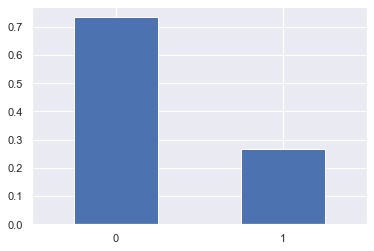

In [40]:
class_frequency=target_ohe.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

Виден дисбаланс целевого признака примерно 3:1
Попробуем побороться встроенной балансировкой моделей, апсемплингом меньшинства и даунсемплингом большинства

In [41]:
features_upsampled, target_upsampled = upsample(features_train_ohe, target_train_ohe, 3)
features_downsampled, target_downsampled = downsample(features_train_ohe, target_train_ohe, 0.35)

### Вывод

Провеены
- [x] нормализация и удаление выбросов 
- [x] исследование на мультиколлинеарность
- [x] исключение незначительных признаков
- [x] кодирование категориальных признаков
- [x] масштабирование количественных признаков 
- [x] проверка на дисбаланс классов и предложены методы избавления от него

## Обучение моделей

Обучим модели логистической регрессии, дерева решений и случайного леса на трех видах выборок - обычной, апсемпл и даунсемпл. 
Выведем метрики для каждой и сравним. Для лучшей модели построим график важности признаков.

### Logistic Regression

=== Balanced === :
Лучшая оценка на валидации:  0.8406395164373197
Лучшие гиперпараметры модели на валидации:  {'C': 10, 'class_weight': None}
Лучшая модель:  LogisticRegression(C=10, n_jobs=-1, random_state=666)
Test Metrics:
Accuracy:  0.809
Presicion:  0.665
Recall:  0.565
AUC-ROC:  0.85


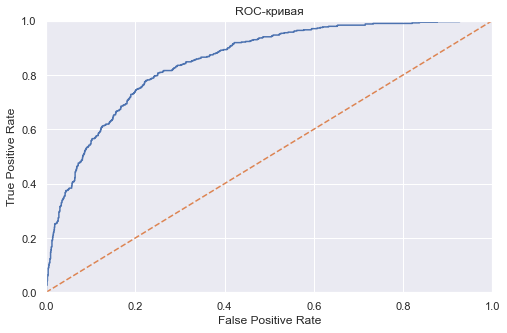

=== Upsampled: === 
Лучшая оценка на валидации:  0.8422898213936199
Лучшие гиперпараметры модели на валидации:  {'C': 20}
Лучшая модель:  LogisticRegression(C=20, n_jobs=-1, random_state=666)
Test Metrics:
Accuracy:  0.746
Presicion:  0.514
Recall:  0.824
AUC-ROC:  0.849


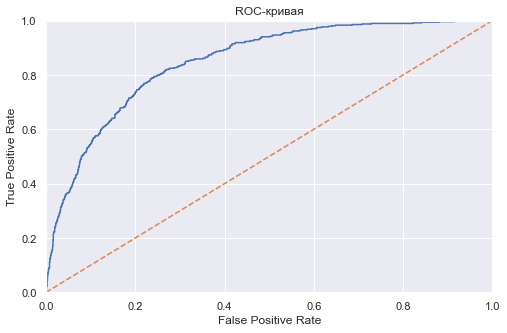

=== Downsampled: ===
Лучшая оценка на валидации:  0.8427566751773263
Лучшие гиперпараметры модели на валидации:  {'C': 5}
Лучшая модель:  LogisticRegression(C=5, n_jobs=-1, random_state=666)
Test Metrics:
Accuracy:  0.753
Presicion:  0.522
Recall:  0.822
AUC-ROC:  0.847


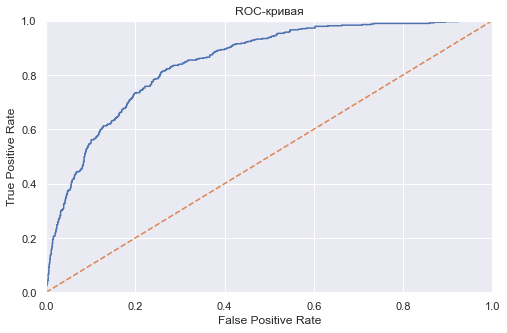

Wall time: 8.14 s


In [42]:
%%time
lr = LogisticRegression(random_state=666, n_jobs=-1)
regress_params_balanced={'class_weight':['balanced',None], 'C':[2, 5, 10, 20]}
regress_params={'C':[2, 5, 10, 20]}

print('=== Balanced === :')
lr_fitted = model_learning(lr, regress_params_balanced ,features_train_ohe, target_train_ohe)
test_scoring(lr_fitted, features_test_ohe, target_test_ohe)

print('=== Upsampled: === ')

lr_fitted_upsampled = model_learning(lr, regress_params ,features_upsampled, target_upsampled)
test_scoring(lr_fitted_upsampled, features_test_ohe, target_test_ohe)

print('=== Downsampled: ===')
lr_fitted_downsampled = model_learning(lr, regress_params ,features_downsampled, target_downsampled)
test_scoring(lr_fitted_downsampled, features_test_ohe, target_test_ohe)

### Decision Tree

=== Balanced === :
Лучшая оценка на валидации:  0.8419477737719466
Лучшие гиперпараметры модели на валидации:  {'class_weight': None, 'max_depth': 6}
Лучшая модель:  DecisionTreeClassifier(max_depth=6, random_state=666)
Test Metrics:
Accuracy:  0.815
Presicion:  0.741
Recall:  0.465
AUC-ROC:  0.844


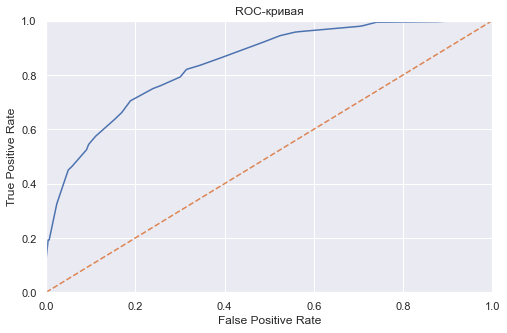

=== Upsampled: === 
Лучшая оценка на валидации:  0.8957335703091914
Лучшие гиперпараметры модели на валидации:  {'max_depth': 16}
Лучшая модель:  DecisionTreeClassifier(max_depth=16, random_state=666)
Test Metrics:
Accuracy:  0.767
Presicion:  0.557
Recall:  0.595
AUC-ROC:  0.724


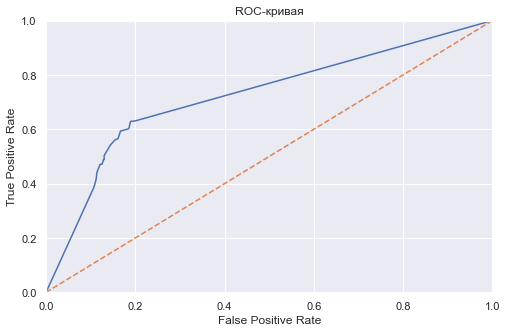

=== Downsampled: ===
Лучшая оценка на валидации:  0.8343441039138403
Лучшие гиперпараметры модели на валидации:  {'max_depth': 6}
Лучшая модель:  DecisionTreeClassifier(max_depth=6, random_state=666)
Test Metrics:
Accuracy:  0.726
Presicion:  0.49
Recall:  0.76
AUC-ROC:  0.826


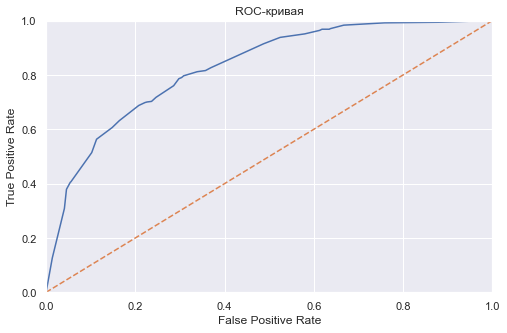

Wall time: 1.2 s


In [43]:
%%time
tree= DecisionTreeClassifier(random_state=666)

tree_params_balanced = {'max_depth': range(1, 17, 5),'class_weight':['balanced',None]}
tree_params = {'max_depth': range(1, 17, 5)}

print('=== Balanced === :')
tree_fitted = model_learning(tree, tree_params_balanced ,features_train_ohe, target_train_ohe)
test_scoring(tree_fitted, features_test_ohe, target_test_ohe)

print('=== Upsampled: === ')

tree_fitted_upsampled = model_learning(tree, tree_params ,features_upsampled, target_upsampled)
test_scoring(tree_fitted_upsampled, features_test_ohe, target_test_ohe)

print('=== Downsampled: ===')
tree_fitted_downsampled = model_learning(tree, tree_params ,features_downsampled, target_downsampled)
test_scoring(tree_fitted_downsampled, features_test_ohe, target_test_ohe)

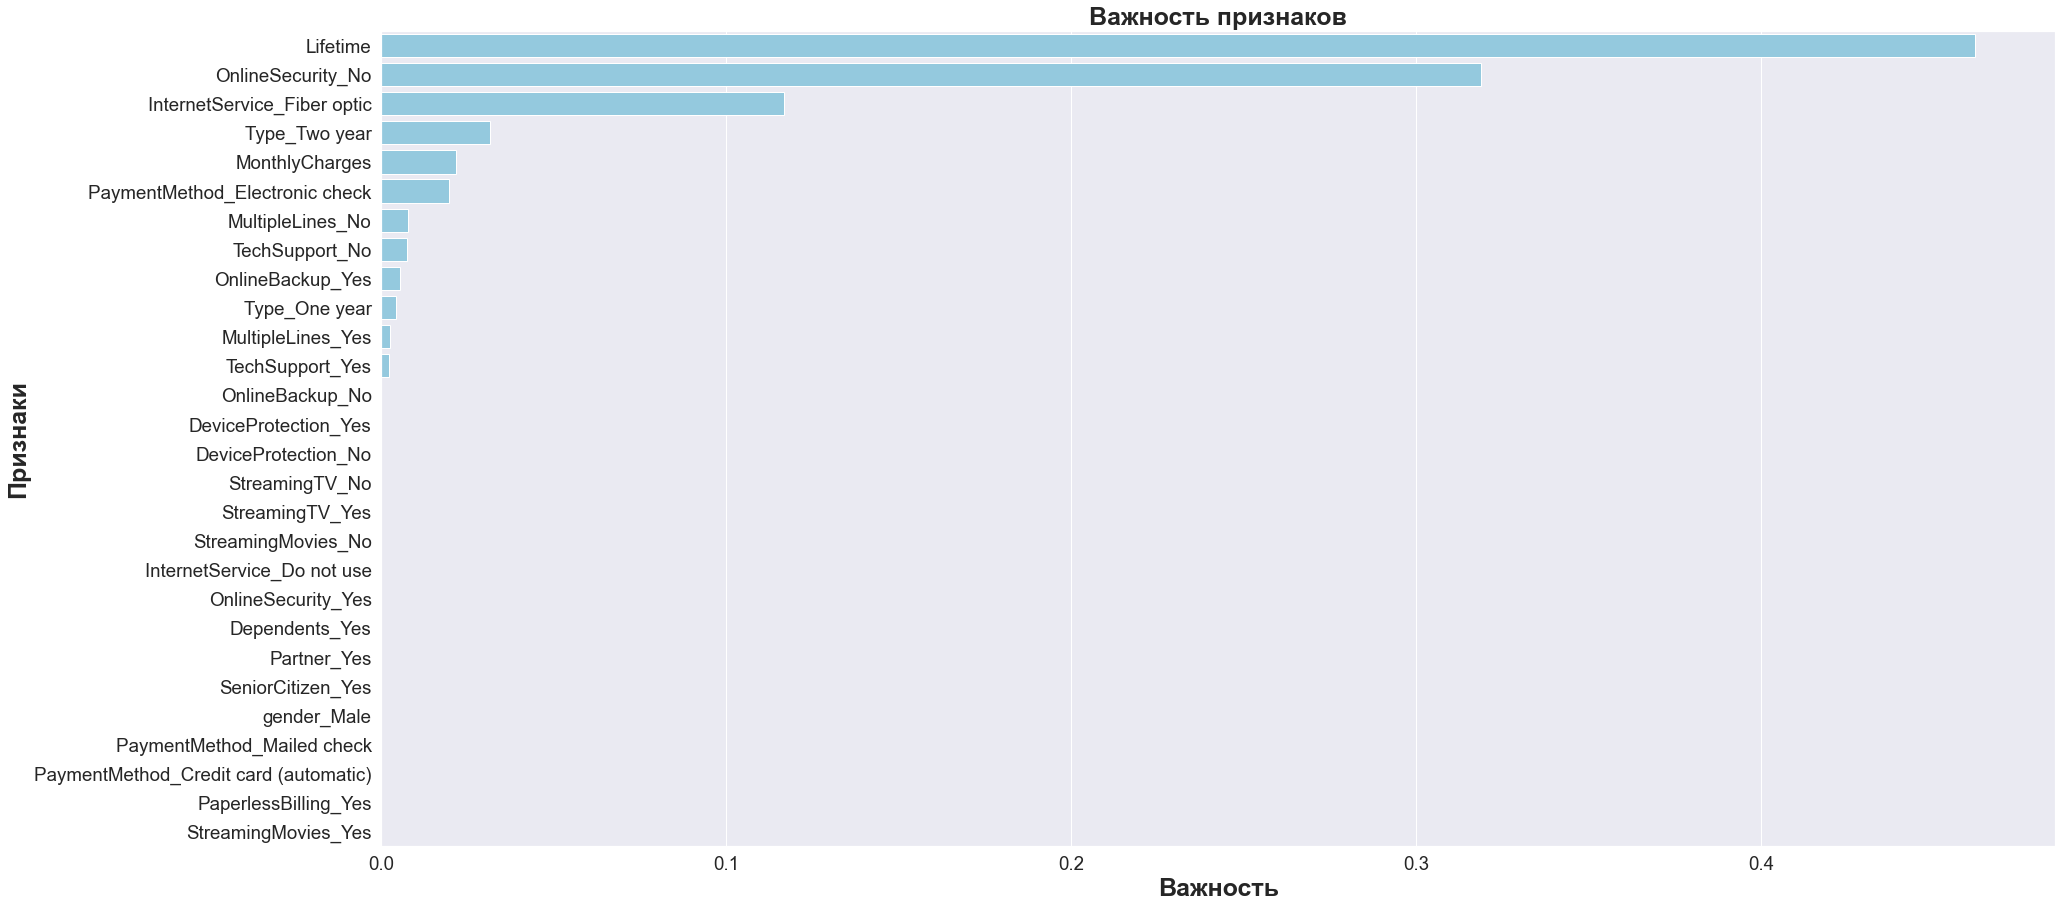

None

,Features,Gini-Importance
0,Lifetime,0.462056
1,OnlineSecurity_No,0.318677
2,InternetService_Fiber optic,0.116740
3,Type_Two year,0.031676
4,MonthlyCharges,0.021612
5,PaymentMethod_Electronic check,0.019506
6,MultipleLines_No,0.007762
7,TechSupport_No,0.007583
8,OnlineBackup_Yes,0.005332
9,Type_One year,0.004338


In [44]:
feature_importance(tree_fitted, features_downsampled)

### Random Forest

=== Balanced === :
Лучшая оценка на валидации:  0.852384330403055
Лучшие гиперпараметры модели на валидации:  {'class_weight': None, 'max_depth': 7, 'n_estimators': 16}
Лучшая модель:  RandomForestClassifier(max_depth=7, n_estimators=16, n_jobs=-1,
                       random_state=666)
Test Metrics:
Accuracy:  0.819
Presicion:  0.703
Recall:  0.548
AUC-ROC:  0.847


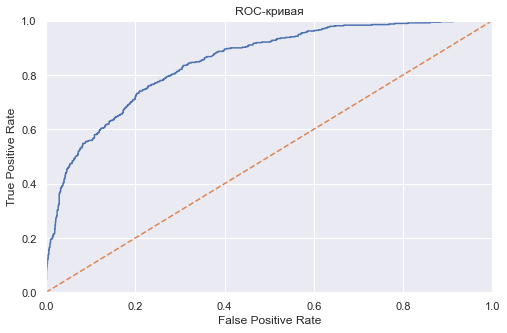

=== Upsampled === :
Лучшая оценка на валидации:  0.9010000441065357
Лучшие гиперпараметры модели на валидации:  {'max_depth': 9, 'n_estimators': 16}
Лучшая модель:  RandomForestClassifier(max_depth=9, n_estimators=16, n_jobs=-1,
                       random_state=666)
Test Metrics:
Accuracy:  0.752
Presicion:  0.522
Recall:  0.773
AUC-ROC:  0.841


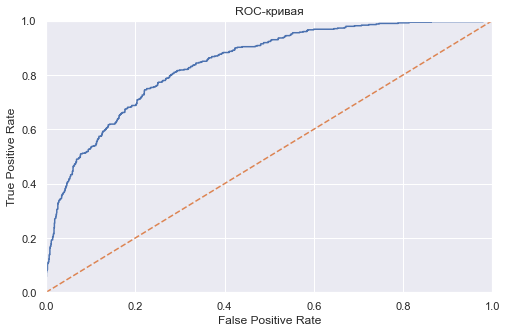

=== Downsampled === :
Лучшая оценка на валидации:  0.8433650763426801
Лучшие гиперпараметры модели на валидации:  {'max_depth': 7, 'n_estimators': 16}
Лучшая модель:  RandomForestClassifier(max_depth=7, n_estimators=16, n_jobs=-1,
                       random_state=666)
Test Metrics:
Accuracy:  0.739
Presicion:  0.505
Recall:  0.801
AUC-ROC:  0.845


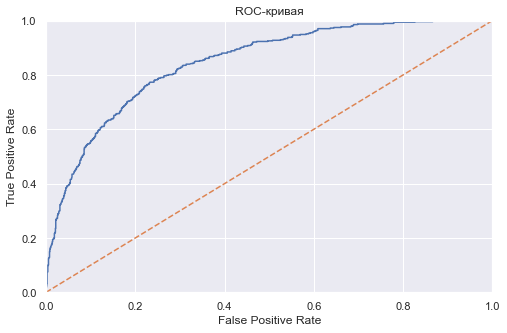

Wall time: 5.72 s


In [45]:
%%time
rf = RandomForestClassifier(random_state=666, n_jobs=-1)
rf_param_balanced = {'max_depth': range(1, 10, 2), 'n_estimators':range(1,21,5), 'class_weight':['balanced',None]}

rf_param = {'max_depth': range(1, 10, 2), 'n_estimators':range(1,21,5)}

print('=== Balanced === :')
rf_fitted = model_learning(rf, rf_param_balanced, features_train_ohe, target_train_ohe)
test_scoring(rf_fitted, features_test_ohe, target_test_ohe)

print('=== Upsampled === :')
rf_fitted_upsampled = model_learning(rf, rf_param, features_upsampled, target_upsampled)
test_scoring(rf_fitted_upsampled, features_test_ohe, target_test_ohe)

print('=== Downsampled === :')
rf_fitted_downsampled = model_learning(rf, rf_param, features_downsampled, target_downsampled)
test_scoring(rf_fitted_downsampled, features_test_ohe, target_test_ohe)

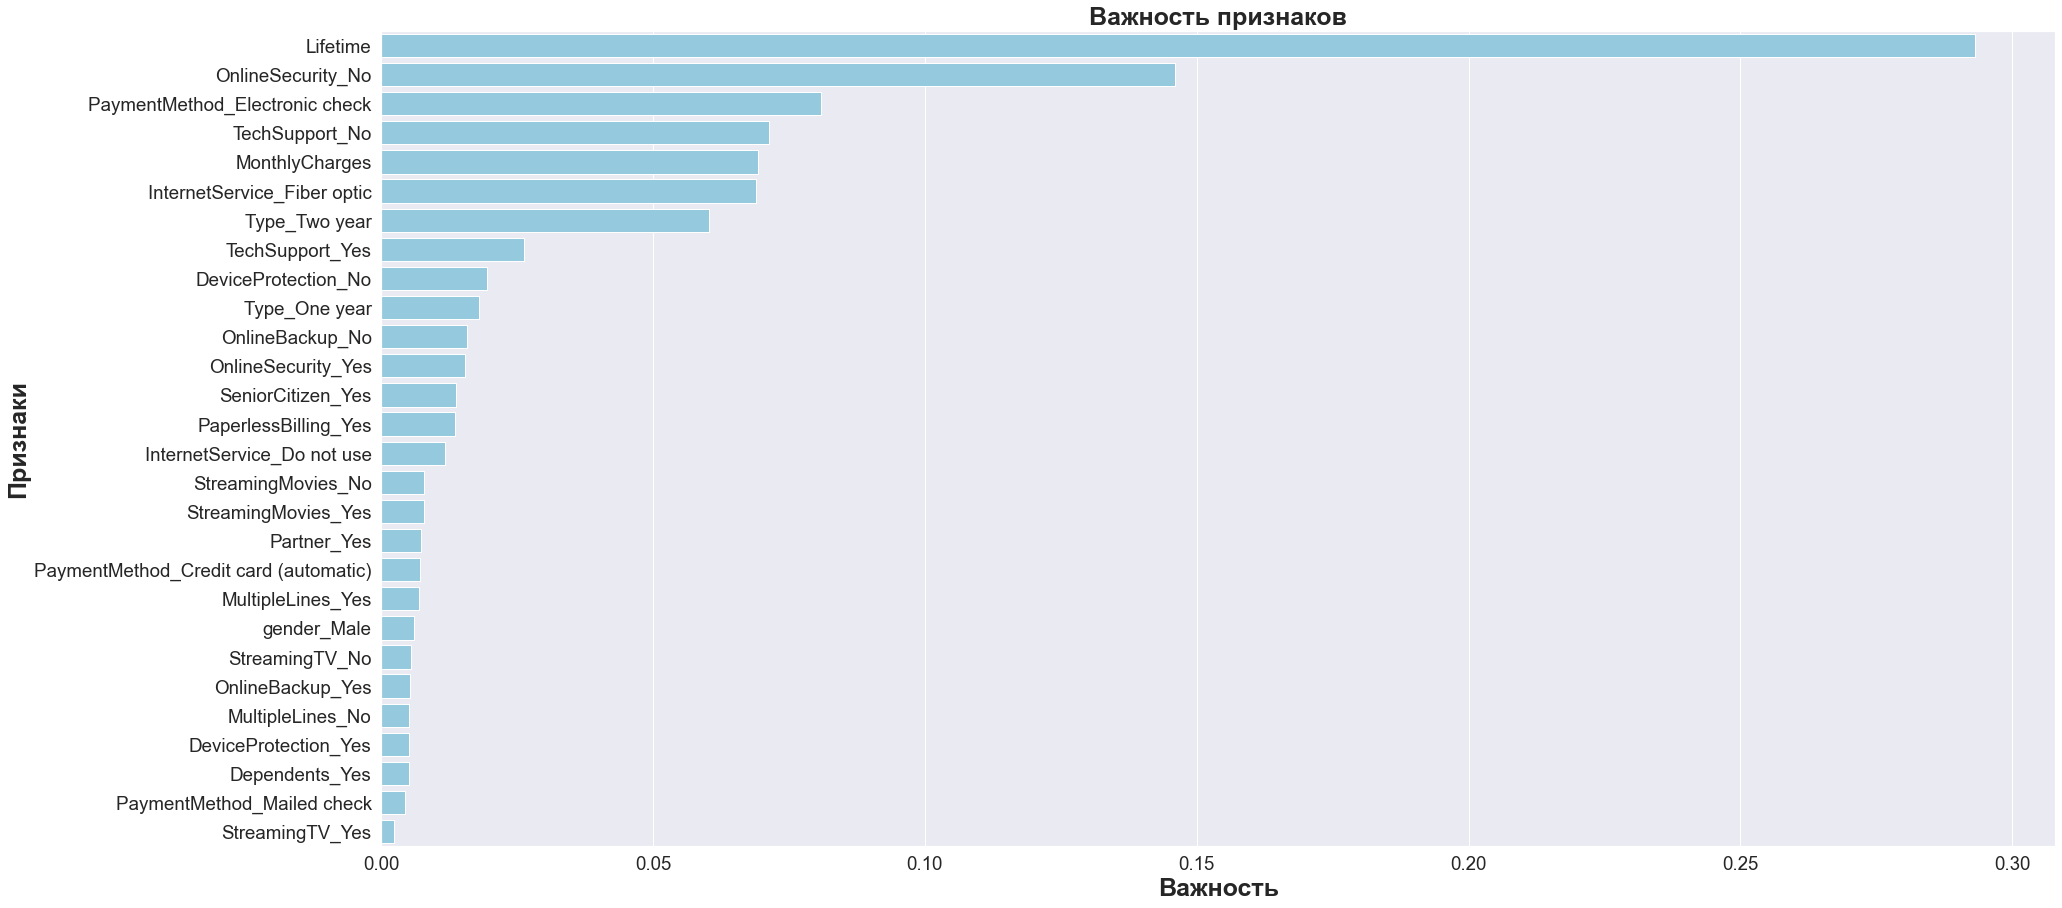

None

,Features,Gini-Importance
0,Lifetime,0.293241
1,OnlineSecurity_No,0.146042
2,PaymentMethod_Electronic check,0.080877
3,TechSupport_No,0.071346
4,MonthlyCharges,0.069260
5,InternetService_Fiber optic,0.068969
6,Type_Two year,0.060318
7,TechSupport_Yes,0.026348
8,DeviceProtection_No,0.019430
9,Type_One year,0.017932


In [46]:
feature_importance(rf_fitted, features_train_ohe)

### Сравнение простых моделей

In [47]:
data_line = {'Модель':['Линейная регрессия' ,'Решающее дерево',  'Случайный лес'],         
        'ROC-AUC без учета баланса': [0.84, 0.841,  0.852],
        'ROC-AUC upsample x3': [0.84, 0.895,  0.901],
       'ROC-AUC downsample x0.35': [0.84,0.834, 0.843]}
data_pivot = pd.DataFrame.from_dict(data_line)
print('На тренировочных данных')
display(data_pivot)

На тренировочных данных


,Модель,ROC-AUC без учета баланса,ROC-AUC upsample x3,ROC-AUC downsample x0.35
0,Линейная регрессия,0.840,0.840,0.840
1,Решающее дерево,0.841,0.895,0.834
2,Случайный лес,0.852,0.901,0.843


In [48]:
data_line = {'Модель':['Линейная регрессия' ,'Решающее дерево',  'Случайный лес'],         
        'ROC-AUC без учета баланса': [0.85, 0.661,  0.848],
        'ROC-AUC upsample x3': [0.849, 0.661,  0.841],
       'ROC-AUC downsample x0.35': [0.847,0.78, 0.845]}
data_pivot = pd.DataFrame.from_dict(data_line)
print('На тестовых данных')
display(data_pivot)

На тестовых данных


,Модель,ROC-AUC без учета баланса,ROC-AUC upsample x3,ROC-AUC downsample x0.35
0,Линейная регрессия,0.850,0.849,0.847
1,Решающее дерево,0.661,0.661,0.780
2,Случайный лес,0.848,0.841,0.845


Вывод: 
На тренировочных данных среди простых моделей лидирует модель Случайного леса, обученная на апсемплированных данных, хотя метрики на тестовых данных говорят, что модель слегка переобучена

### LbGm

[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
Лучшая оценка на валидации:  0.9057073279716302
Лучшие гиперпараметры модели на валидации:  {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
Лучшая модель:  LGBMClassifier(l2_leaf_reg=1, max_depth=5, n_estimators=500, random_state=666)
Test Metrics:
Accuracy:  0.858
Presicion:  0.79
Recall:  0.636
AUC-ROC:  0.907


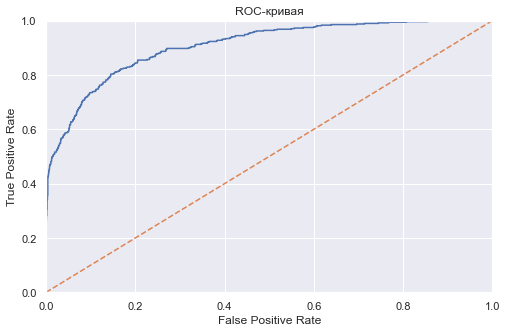

Wall time: 23.5 s


In [49]:
%%time
lgbm= LGBMClassifier(n_jobs=-1, random_state=666)
lgbm_param = {'n_estimators': [300, 500, 1000],
                  'learning_rate': [0.01, 0.1, 1],
                  'max_depth': [1, 5, 9],
                  'l2_leaf_reg': [1, 3]}
    
lgbm_fitted = model_learning(lgbm, lgbm_param, features_train_ohe, target_train_ohe)
test_scoring(lgbm_fitted, features_test_ohe, target_test_ohe)

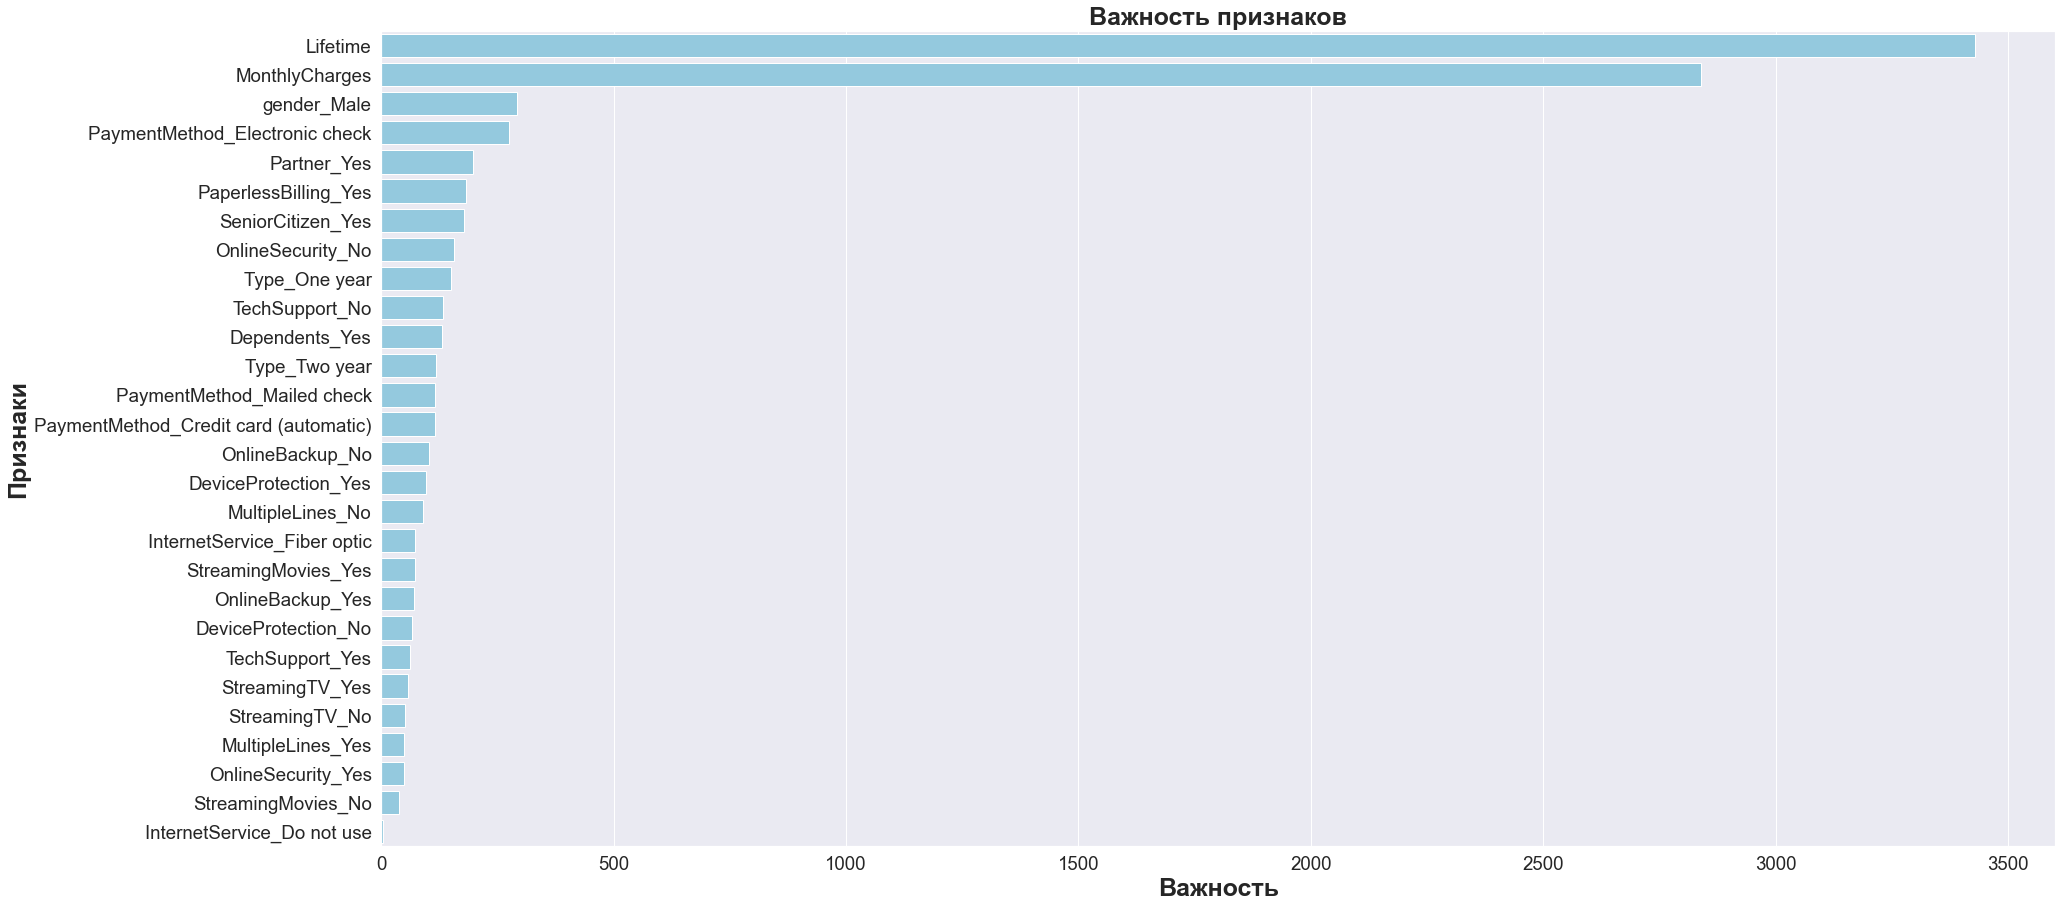

None

,Features,Gini-Importance
0,Lifetime,3430
1,MonthlyCharges,2839
2,gender_Male,293
3,PaymentMethod_Electronic check,275
4,Partner_Yes,197
5,PaperlessBilling_Yes,183
6,SeniorCitizen_Yes,179
7,OnlineSecurity_No,157
8,Type_One year,151
9,TechSupport_No,134


In [50]:
feature_importance(lgbm_fitted, features_test_ohe)

### CatBoost

In [51]:
target = df_full['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
features = df_full.drop(['Churn'], axis=1)  



features_train, features_test, target_train, target_test = train_test_split(
        features,target,stratify=target, test_size=0.25, random_state=666)

scaler=StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric]=scaler.transform(features_train[numeric])
features_test[numeric]=scaler.transform(features_test[numeric])

print('Обучающая выборка: ', features_train.shape,  target_train.shape)
print('Тестовая выборка: ', features_test.shape,  target_test.shape)

Обучающая выборка:  (5274, 17) (5274,)
Тестовая выборка:  (1758, 17) (1758,)


In [53]:
# %%time
cat_features=['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
catboost = CatBoostClassifier(random_state=666, cat_features=cat_features, iterations=200, loss_function="Logloss")
catboost_param = params={'depth': range(5, 10, 15), 'learning_rate': [0.5, 0.8, 1.0]}



catboost_fitted = model_learning(catboost, catboost_param, features_train, target_train)


0:	learn: 0.4852246	total: 187ms	remaining: 37.1s
1:	learn: 0.4246033	total: 214ms	remaining: 21.2s
2:	learn: 0.4096160	total: 240ms	remaining: 15.8s
3:	learn: 0.3960707	total: 269ms	remaining: 13.2s
4:	learn: 0.3904576	total: 302ms	remaining: 11.8s
5:	learn: 0.3844976	total: 326ms	remaining: 10.5s
6:	learn: 0.3834927	total: 366ms	remaining: 10.1s
7:	learn: 0.3808325	total: 399ms	remaining: 9.57s
8:	learn: 0.3784794	total: 437ms	remaining: 9.28s
9:	learn: 0.3783752	total: 457ms	remaining: 8.68s
10:	learn: 0.3776921	total: 494ms	remaining: 8.49s
11:	learn: 0.3749746	total: 528ms	remaining: 8.27s
12:	learn: 0.3659890	total: 554ms	remaining: 7.97s
13:	learn: 0.3645415	total: 585ms	remaining: 7.76s
14:	learn: 0.3645210	total: 614ms	remaining: 7.57s
15:	learn: 0.3633935	total: 639ms	remaining: 7.34s
16:	learn: 0.3581904	total: 690ms	remaining: 7.43s
17:	learn: 0.3566361	total: 718ms	remaining: 7.26s
18:	learn: 0.3541613	total: 770ms	remaining: 7.34s
19:	learn: 0.3522071	total: 806ms	remaini

Test Metrics:
Accuracy:  0.865
Presicion:  0.785
Recall:  0.679
AUC-ROC:  0.916


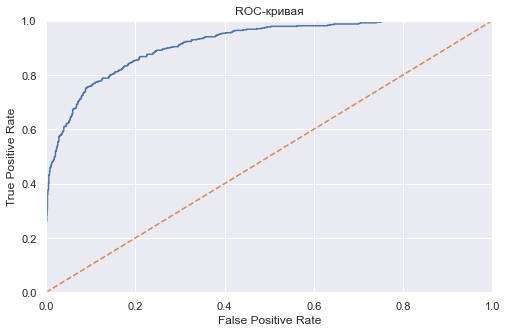

In [54]:
test_scoring(catboost_fitted, features_test, target_test)

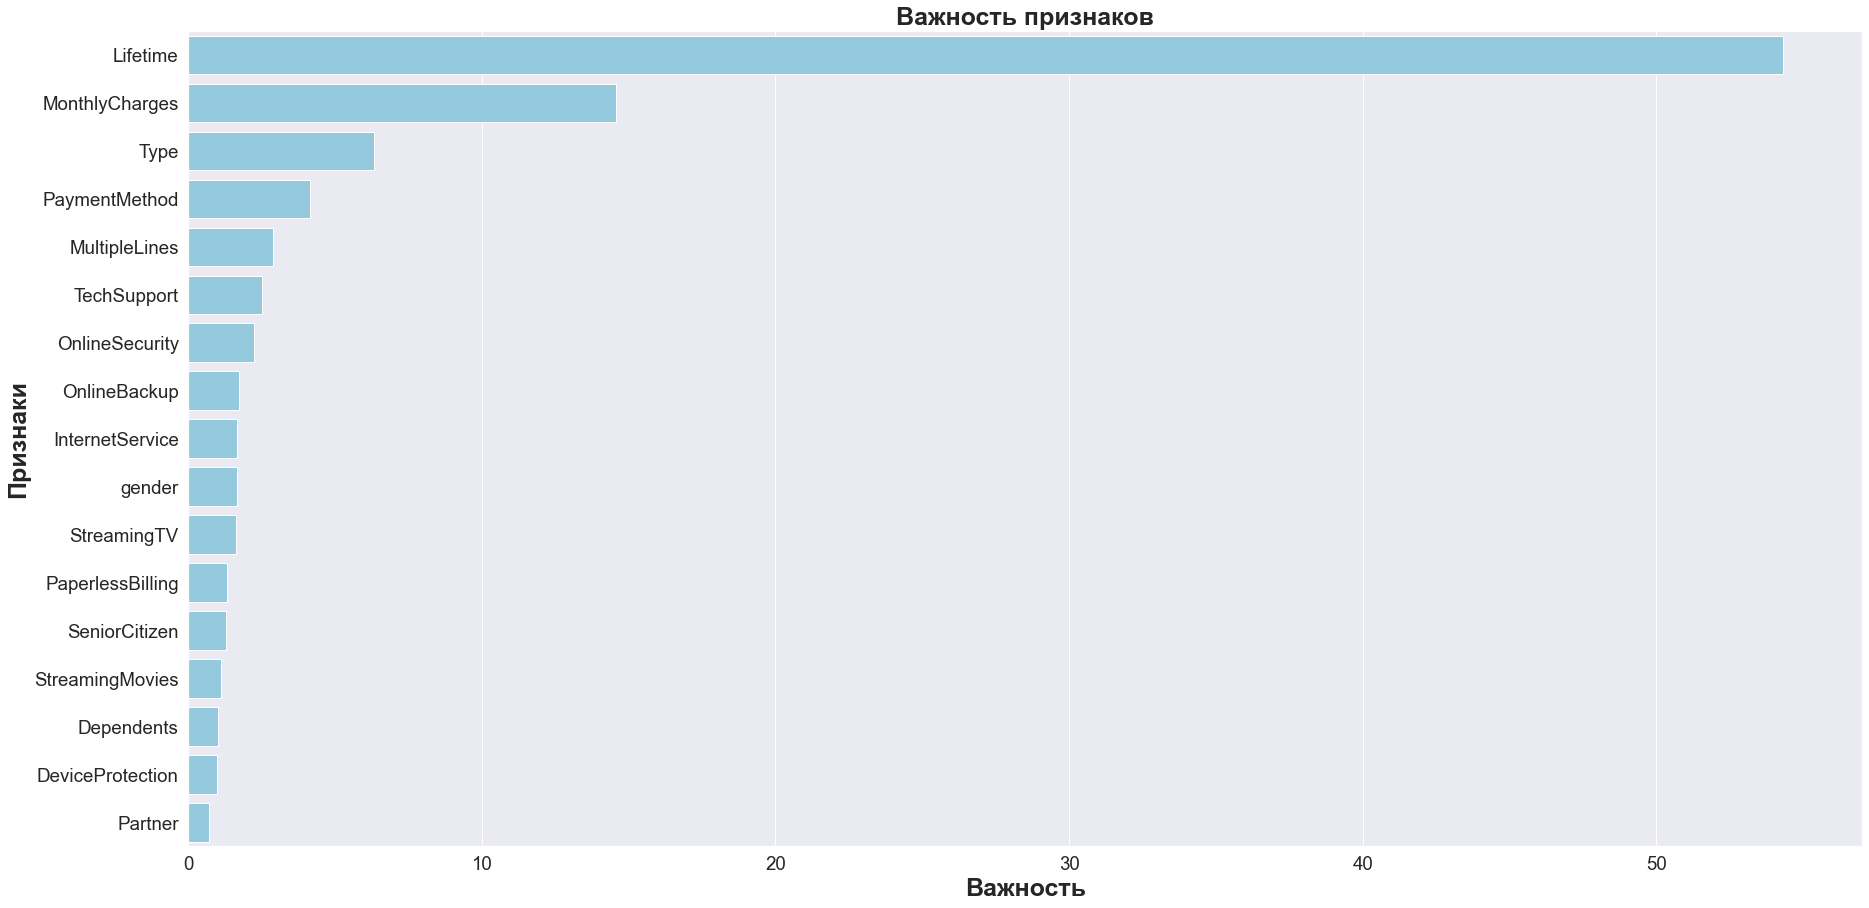

None

,Features,Gini-Importance
0,Lifetime,54.304327
1,MonthlyCharges,14.552922
2,Type,6.334088
3,PaymentMethod,4.141840
4,MultipleLines,2.870313
5,TechSupport,2.497794
6,OnlineSecurity,2.231903
7,OnlineBackup,1.718612
8,InternetService,1.660146
9,gender,1.658015


In [55]:
feature_importance(catboost_fitted, features_train)

Отбросим неважные признаки

In [56]:
cat_features_filterred = ['Type',
               'PaymentMethod','MultipleLines','OnlineBackup','InternetService',
               'TechSupport','OnlineSecurity']
features_train_filtered = features_train.drop(['Dependents','Partner','DeviceProtection','StreamingMovies',
                    'SeniorCitizen','StreamingTV','gender','PaperlessBilling'],axis =1 )
features_test_filtered = features_test.drop(['Dependents','Partner','DeviceProtection','StreamingMovies',
                    'SeniorCitizen','StreamingTV','gender','PaperlessBilling'], axis =1)

Test Metrics:
Accuracy:  0.87
Presicion:  0.81
Recall:  0.668
AUC-ROC:  0.921


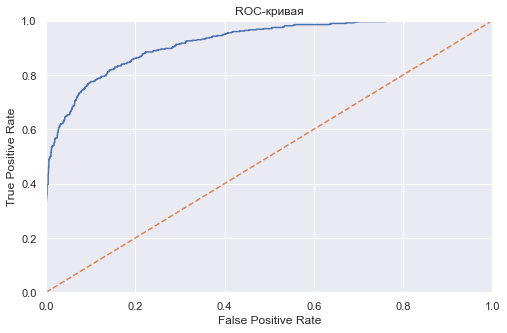

In [62]:
cat_test = CatBoostClassifier(iterations= 200, verbose=0,cat_features=cat_features_filterred, 
                        learning_rate=0.5,depth=5, random_state=666)
cat_test.fit(features_train_filtered, target_train)
test_scoring(cat_test, features_test_filtered, target_test)
# predictions_cat=cat_test.predict(features_test_filtered)
# probabilities_test =cat_test.predict_proba(features_test_filtered)
# probabilities_one_test = probabilities_test[:,1]


### Нейронная сеть

In [63]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


In [64]:
for gpu in gpus:
 tf.config.experimental.set_memory_growth(gpu, True)

In [65]:
optimizer = Adam(lr=0.0001)
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=500, input_dim=features_train_ohe.shape[1],activation='relu'))
model.add(keras.layers.Dense(units=250, activation='relu'))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])
model.fit(features_train_ohe, target_train_ohe, validation_data =(features_test_ohe, target_test_ohe), verbose=2, epochs=4, batch_size=10)

Epoch 1/4
528/528 - 4s - loss: 0.4507 - acc: 0.7814 - val_loss: 0.4179 - val_acc: 0.7964
Epoch 2/4
528/528 - 2s - loss: 0.4212 - acc: 0.7952 - val_loss: 0.4155 - val_acc: 0.8049
Epoch 3/4
528/528 - 2s - loss: 0.4157 - acc: 0.8013 - val_loss: 0.4157 - val_acc: 0.8043
Epoch 4/4
528/528 - 2s - loss: 0.4111 - acc: 0.8049 - val_loss: 0.4149 - val_acc: 0.8043


Test Metrics:
Accuracy:  0.865
Presicion:  0.785
Recall:  0.679
AUC-ROC:  0.806


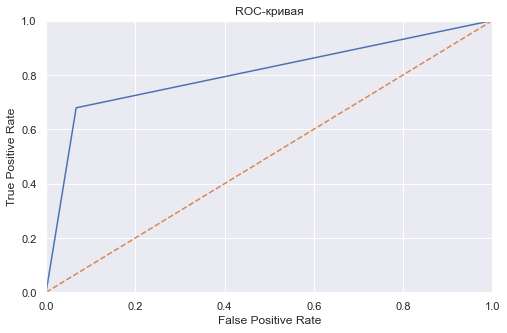

In [66]:

test_scoring(catboost_fitted, features_test, target_test, True)

Ну...не в этот раз

### Константная модель

In [67]:
constant=[[0]]*target_test.shape[0]
roc_auc=roc_auc_score(target_test, constant)
roc_auc

0.5

Любая из предоставленных выше моделей превосходит константную модель

## Вывод

Лучше всего себя показала модель градиентного бустинга CatBoost с параметрами {'depth': 5, 'learning_rate': 0.5} при 200 итерациях. Уровень **AUC-ROC** на тестовой выборке достиг **0.921** и **0.905** на обучающей.
Второе место заняла модель LGBMClassifier(l2_leaf_reg=1, max_depth=5, n_estimators=500, random_state=666). Ее уровень **AUC-ROC** на тестовой выборке достиг **0.908** и **0.906** на обучающей.

Обе модели показали, что считают самым влияющим показателем ухода клиента его *Lifetime* а так же ежемесячную оплату, хотя исходя из вывода секции анализа данных тоже можно найти разные теории.

Цель достигнута. Можно рекомендовать дееспособную модель CatBoot {'depth': 5, 'learning_rate': 0.5, iterations:200}, которая показала метрики

* Accuracy:  0.87

* Presicion:  0.81

* Recall:  0.668

* AUC-ROC:  0.921

или модель LGBMClassifier(l2_leaf_reg=1, max_depth=5, n_estimators=500, random_state=666) почти с идентичными метриками

## Отчет

### Какие пункты плана были выполнены, а какие — нет (поясните почему)

Все пункты из плана были выполнены. Также добавлена попытка ииспольвания нейронной сети

1. [x] Exploratory Data Analysis
    - [X] определиться, что делать с пропусками
    - [X] создать столбец с бинарным целевым признаком, зависящим от даты окончания (ее наличия?) контракта 
    - [X] аккуратное объединение датафреймов в один. Мердж по убыванию кол-ва данных к самому большому, чтобы ничего не потерять. Надо еще посмотреть, может добавить какие-то доп составные признаки с помощью сводных таблиц или расчетов (например, сколько дней длился контракт пользователя)
2. [x] Исследовательский анализ данных
    - [X] распределения данніх о  ежемесячных платежах всех клиентов и тех, кто ушел
    - [X] статистические метрики для всех клиентов, и тех, кто ушел: среднее, мин, макс, медиана, квантили
    - [X] графики с долями клиентов, которые используют интернет, телефонию и обе услуги
    - [X] графики с долями клиентов, которые используют доп услуги
3. [x] Подготовить данные для моделей
    - [x] нормализация и удаление выбросов 
    - [x] исследование на мультиколлинеарность
    - [x] исключение незначительных признаков
    - [x] кодирование категориальных признаков
    - [x] масштабирование количественных признаков 
    - [x] проверка на дисбаланс классов и избавление, если таковой имеется
4. [x] Обучение простых моделей с автоподбором параметров.
5. [x] Попробовать градиентный бустинг (например модели CatBoost и LightBGM)
6. [x] Выбор, тестирование лучшей модели и сравнение ее с Dummy моделью
7. [x] Выводы, отчет

### Какие трудности возникли и как вы их преодолели

- Установка и настройка Keras, Tensorflow-gpu с conda

- Изначальное неверное скалирование числовых признаков по всему датафрейму. После скалирования уже разделенных выборок - метрики изменились

- Неудобство категориальніх данных. Где-то 0 и 1, где-то yes-no. привелось все к единому виду

- Нейронная сеть имеет низкие показатели. Но т.к. в решении уже есть модели лучше/проще, то она была оставлена просто для примера

### Какие ключевые шаги в решении задачи выделили?

В предобработке и анализе данных важную роль сыграло:

- удаление пропусков

- добавление целевого признака

- объединение данных в один датафрейм

- избавление от сильно коррелирующий признаков

- кодирование категориальных признаков и масштабирование количественных

- удаление дат

В обучении и сравнении моделей:

- Выведены метрики

- Выведены признаки, которые модель считает важной

- Удалены неважные признаки, что поспособствовало увеличению метрики

- Выделена и протестирована лучшая модель

Также:

- Анализ данных был проведен, но критичных изменений, кроме описанных выше сделано не было.

- Были выделены несколько гипотез для дальнейшего рассмотрения


### Какая ваша итоговая модель и какое у неё качество?

Рекомендованная модель к деплойменту - *CatBoostClassifier(iterations= 200, verbose=0,cat_features=cat_features_filterred, learning_rate=0.5,depth=5, random_state=666)*, обученная на данных без признаков 
['Dependents','Partner','DeviceProtection','StreamingMovies',
                    'SeniorCitizen','StreamingTV','gender','PaperlessBilling']

Ее метрики на тестовых данных:

- Accuracy:  0.87

- Presicion:  0.81

- Recall:  0.668

- AUC-ROC:  0.921